# Practical Work 3 - First experiment : Natural men vs natural women

Authors : Lionel Burgbacher & David Jaquet

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

%matplotlib inline

In [2]:
PATH = './vowels/'

## Utils

In [3]:
# Read all the wav files
def read_files(files):
    readed = []
    
    for file in files:
        readed.append(wav.read(os.path.join(PATH, file)))
    
    return readed

# Generate the Mel-Frequency Cepstrum Coefficients
def generate_mfcc(files):
    mfcc_array = []
    for (rate, X) in files:
        mfcc_array.append(mfcc(X, samplerate=rate, nfft=1024))
        
    return mfcc_array

# Calculate the mean of the features for the given array
def calculate_feature_mean(mfcc):
    feature_mean = []
    
    for feature in mfcc:
        mean = np.mean(feature,axis=0)
        feature_mean.append(mean)
    return feature_mean

# Calculate the median of the features for the given array
def calculate_feature_std(mfcc):
    feature_std = []
    
    for feature in mfcc:
        deviation = np.std(feature,axis=0)
        feature_std.append(deviation)
    return feature_std

# Calculate the standard deviation of the features for the given array
def calculate_feature_median(mfcc):
    feature_median = []
    
    for feature in mfcc:
        median = np.median(feature,axis=0)
        feature_median.append(median)
    return feature_median

# Normalize data per columns between min and max
def scale(array, min, max):
    nom = (array-array.min(axis=0))*(max-min)
    denom = array.max(axis=0) - array.min(axis=0)
    denom[denom==0] = 1
    return min + nom/denom

## Experiment

In [4]:
# src : https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
# Collect all the men files
men_files = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('nam') and file.endswith('.wav'))]

# Collect all the women files
women_files = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('naf') and file.endswith('.wav'))]

In [5]:
men = read_files(men_files)
women = read_files(women_files)
    
men_mfcc = generate_mfcc(men)
women_mfcc = generate_mfcc(women)

men_feature = calculate_feature_median(men_mfcc)
women_feature = calculate_feature_median(women_mfcc)

In [6]:
# Append all the datas
datas = []
MAN = [-1]
WOMAN = [1]

for feature in men_feature:
    datas.append(np.append(feature, MAN))

for feature in women_feature:
    datas.append(np.append(feature, WOMAN))
    
datas = scale(np.asarray(datas), -1, 1)

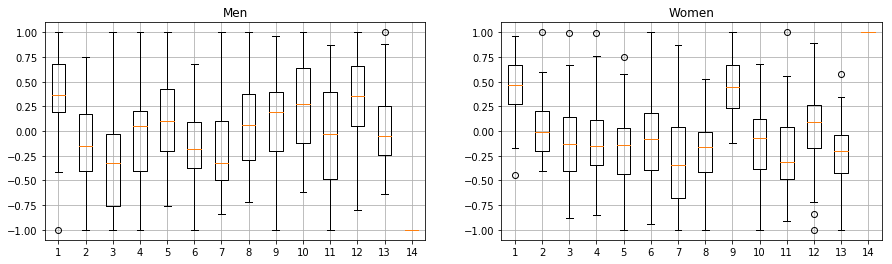

In [7]:
pl.figure(figsize=(15,4))
pl.subplot(1,2,1)
pl.boxplot(datas[:36])
pl.title('Men')
pl.grid()
pl.subplot(1,2,2)
pl.boxplot(datas[36:])
pl.title('Women')
pl.grid()

In [8]:
N_INITS = 10
EPOCHS = 1000
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

input_data = datas[:,0:13]
output_data = datas[:,13]

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    
    # 13 features in input and 1 output to determine man or woman
    nn = mlp.MLP([13, h, 1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((input_data, output_data),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


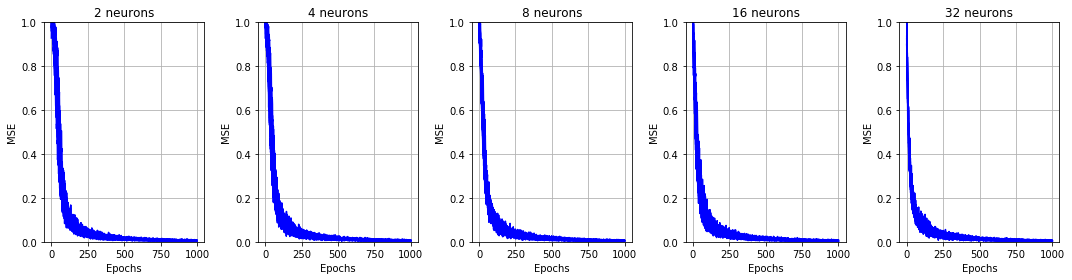

In [9]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

Dans les graphiques ci-dessus, on peut voir que le `MSE` se stabilise, quel que soit le nombre de neurones à partir de **400 epochs**. Nous avons donc de choisir cette valeur d'epochs pour la suite de l'expérience.

In [10]:
K = 5
N_TESTS = 10
EPOCHS = 400
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [11]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13, h, 1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            datas,      # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


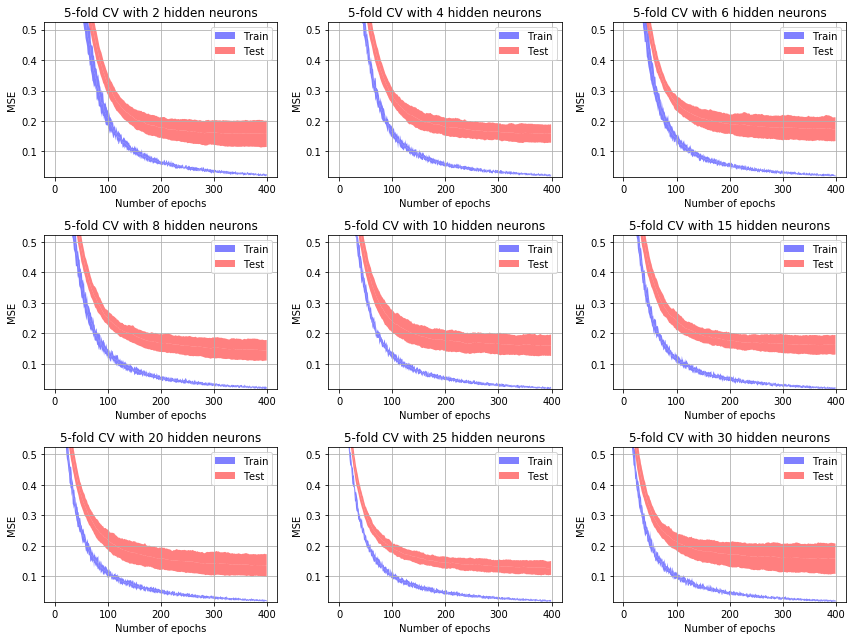

In [12]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

Les graphiques ci-dessus démontrent que les erreurs les moins fréquentes sont avec **4, 15 et 20 et 25 neurones**.

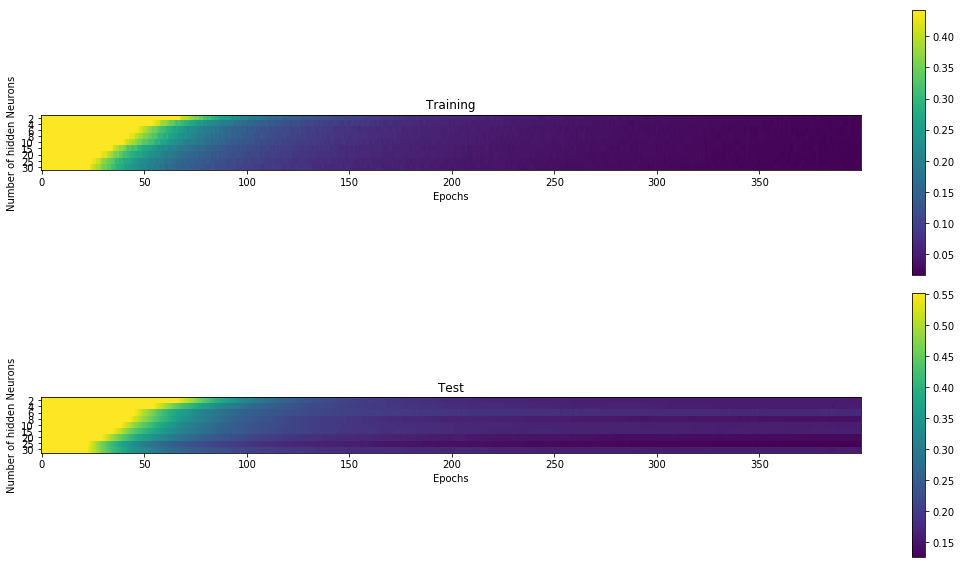

In [13]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

Selon ces graphiques, la version à 25 neurones est la meilleure.

In [14]:
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.5
EPOCHS = 400
N_NEURONS = 25

In [15]:
nn = mlp.MLP([13, N_NEURONS, 1], 'tanh')

# Initialize to -1 to be sure they are updated
best_MSE_train = -1
best_MSE_test = -1
best_f_score = -1

# Initialize to 2 to be sure they are updated
worst_MSE_train = 2
worst_MSE_test = 2
worst_f_score = 2

worst_conf_mat = np.zeros((2, 2))
best_conf_mat = np.zeros((2, 2))
total_results = np.zeros((2, 2))

mean_MSE_train = 0
mean_MSE_test = 0

for i in range(0, 100):
    MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                               datas,
                                                               k=K,
                                                               learning_rate=LEARNING_RATE,
                                                               momentum=MOMENTUM,
                                                               epochs=EPOCHS,
                                                               threshold=0.0)
    if best_MSE_train < MSE_train:
        best_MSE_train = MSE_train
    elif worst_MSE_train > MSE_train:
        worst_MSE_train = MSE_train
        
    if best_MSE_test < MSE_test:
        best_MSE_test = MSE_test
    elif worst_MSE_test > MSE_test:
        worst_MSE_test = MSE_test
        
    total_results[0][0] += conf_mat[0][0]
    total_results[0][1] += conf_mat[0][1]
    total_results[1][0] += conf_mat[1][0]
    total_results[1][1] += conf_mat[1][1]
    
    mean_MSE_train += MSE_train
    mean_MSE_test += MSE_test
        
    if best_conf_mat[0][0] + best_conf_mat[1][1] < conf_mat[0][0] + conf_mat[1][1]:
        best_conf_mat = conf_mat
    elif worst_conf_mat[0][1] + worst_conf_mat[1][0] < conf_mat[0][1] + conf_mat[1][0]:
        worst_conf_mat = conf_mat


In [54]:
print("Worst MSE training: ".ljust(20, ' '), worst_MSE_train)
print("Best MSE training: ".ljust(20, ' '), best_MSE_train)
print("Worst MSE test: ".ljust(20, ' '), worst_MSE_test)
print("Best MSE test: ".ljust(20, ' '), best_MSE_test)
print("\nBest confusion matrix:")
print(best_conf_mat)
print("\nWorst confusion matrix:")
print(worst_conf_mat)

# total_results[0][0] = TP
# total_results[0][1] = FN
# total_results[1][0] = FP
# total_results[1][1] = TN

total_results[0][0] /= 100
total_results[0][1] /= 100
total_results[1][0] /= 100
total_results[1][1] /= 100
print("\nMean matrix:")
print(total_results)

# precision = tp/(tp + fp)
mean_precision = total_results[0][0] / (total_results[0][0] + total_results[1][0])
print("\nMean precision: ".ljust(21, ' '), mean_precision)

# recall = tp/(tp + fn)
mean_recall = total_results[0][0] / (total_results[0][0] + total_results[0][1])
print("Mean recall: ".ljust(20, ' '), mean_recall)

# F1 Score = 2 x precision x recall / ( precision + recall)
mean_f1 = 2 * mean_precision * mean_recall / (mean_precision + mean_recall)
print("Mean F1 Score: ".ljust(20, ' '), mean_f1)

Worst MSE training:  0.01719991816238013
Best MSE training:   0.021769008270510808
Worst MSE test:      0.07964923472337604
Best MSE test:       0.26782341594394854

Best confusion matrix:
[[35.  1.]
 [ 0. 36.]]

Worst confusion matrix:
[[35.  1.]
 [ 7. 29.]]

Mean matrix:
[[34.54  1.46]
 [ 2.11 33.89]]

Mean precision:      0.9424283765347885
Mean recall:         0.9594444444444444
Mean F1 Score:       0.9508602890571232
